In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import json

# Partie 1:
## Import des datasets

In [2]:
df_london_weather = pd.DataFrame(pd.read_excel(r'./datasets/Weather Data 2014-11-30.xlsx', sheet_name='Weather Data'))
df_london_pv = pd.DataFrame(pd.read_csv(r'./datasets/EXPORT HourlyData - Customer Endpoints.csv', low_memory=False))

In [3]:
df_london_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69480 entries, 0 to 69479
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Site          69480 non-null  object        
 1   Date          69480 non-null  datetime64[ns]
 2   Month         69480 non-null  int64         
 3   Time          69480 non-null  object        
 4   Hour          69480 non-null  int64         
 5   TempOut       69480 non-null  object        
 6   HiTemp        69480 non-null  object        
 7   LowTemp       69480 non-null  object        
 8   OutHum        69480 non-null  object        
 9   DewPt         69480 non-null  object        
 10  WindSpeed     69480 non-null  int64         
 11  WindDir       69480 non-null  object        
 12  WindRun       69480 non-null  float64       
 13  HiSpeed       69480 non-null  int64         
 14  HiDir         69480 non-null  object        
 15  WindChill     69480 non-null  object

In [4]:
df_london_pv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52352 entries, 0 to 52351
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SerialNo                       52352 non-null  object 
 1   Substation                     52352 non-null  object 
 2   datetime                       52352 non-null  object 
 3   t_date                         52352 non-null  object 
 4   t_time                         52352 non-null  object 
 5   d_y                            52352 non-null  int64  
 6   d_m                            52352 non-null  int64  
 7   d_d                            52352 non-null  int64  
 8   d_w                            52352 non-null  int64  
 9   t_h                            52352 non-null  int64  
 10  t_m                            52352 non-null  int64  
 11  V_MIN                          52352 non-null  float64
 12  V_MIN_Filtered                 52352 non-null 

In [5]:
print(max(df_london_pv["I_GEN_MIN"]))
print(min(df_london_pv["I_GEN_MIN"]))


13.401
0.396


In [6]:
#Verif si c'est bien Solar Rad pour l'UV Index 
solarEnergy = max(df_london_weather["SolarRad"].replace("---", np.nan).dropna())

print("index UV max sur 1/2h sur l'année: " + str((solarEnergy+18.365)/104))

index UV max sur 1/2h sur l'année: 9.830432692307692


In [7]:
#Get des colonnes permettant d'avoir la production d'un site à une date donné
df_london_pv_useful_data = df_london_pv[["Substation", "datetime", "t_time", "d_m", "d_d", "I_GEN_MIN"]]
df_london_pv_useful_data = df_london_pv_useful_data.rename(columns = {"Substation": "Site", "t_time":"Time", "d_m":"Month", "d_d":"Day"})


#Get des colonnes permettant d'avoir l'indice UV suivant une tranche d'1/2 heure tant que l'indice SolarEnergy > 0
#Get colonnes  utiles
df_london_weather_solarEnergy_half_hour =  df_london_weather[["Site", "Date", "Month", "Time", "SolarRad"]]
#replace --- by NaN & drop NaN
df_london_weather_solarEnergy_half_hour = df_london_weather_solarEnergy_half_hour.replace("---", np.nan).dropna()

In [8]:
#Verification weather Data
df_london_weather_solarEnergy_half_hour.head()

,Site,Date,Month,Time,SolarRad
0,YMCA,2014-01-07,1,14:30:00,32.0
1,YMCA,2014-01-07,1,15:00:00,20.0
2,YMCA,2014-01-07,1,15:30:00,22.0
3,YMCA,2014-01-07,1,16:00:00,8.0
4,YMCA,2014-01-07,1,16:30:00,0.0


In [9]:
#Verification pv Data
df_london_pv_useful_data.head()

,Site,datetime,Time,Month,Day,I_GEN_MIN
0,Forest Road,2013-10-01 12:00:00,12:00:00,10,1,8.391
1,Forest Road,2013-10-01 13:00:00,13:00:00,10,1,4.514
2,Forest Road,2013-10-01 14:00:00,14:00:00,10,1,3.548
3,Forest Road,2013-10-01 15:00:00,15:00:00,10,1,2.520
4,Forest Road,2013-10-01 16:00:00,16:00:00,10,1,1.552


## Informations complémentaires pour le tri

Suite aux questions posées à une personne du milieu il a été expliciter que:
 *  Pour "__automne, hiver__" il a été mentionné que les panneaux solaires démarrais au plus tard vers __9h__ pour finir au pire leur journée de production vers __16h__.  
     *  Par conséquent j'isole les données pour que de l'automne jusqu'à la fin de l'hiver les données dans l'intervalle [__8h__, __17h__] pour prendre en compte que peut être lors du passage été => automne.
 *  Pour la période estivale "__printemps, été__" il a été mentionné que les panneaux solaires commencent leur productions vers __7h__ pour finir vers __20h__.
     *  Par conséquent  j'isole les données dans l'intervalle [__7h__,__20h__] pour le printemps et l'été.  
     

In [10]:
winter_months = [9,10,11,12,1,2,3]
begin_winter_day = 22
end_winter_day = 20

winter_hours = [datetime.strptime("8:00:00", "%H:%M:%S").time(), datetime.strptime("17:00:00", "%H:%M:%S").time()]
summer_hours = [datetime.strptime("7:00:00", "%H:%M:%S").time(), datetime.strptime("20:00:00", "%H:%M:%S").time()]

In [11]:
#Premier Tri des données sur la date pour les données PV
dataset_pv = []
for index, row in df_london_pv_useful_data.iterrows():
    r = None
    if row["Month"] in winter_months:
        if row["Month"] == 9 and row["Day"] >= begin_winter_day:
            r = row
        elif row["Month"] == 3 and row["Day"] <= end_winter_day:
            r = row
        else:
            r = row
        if r is not None:
            time = datetime.strptime(r["Time"], "%H:%M:%S").time()
            if time >= winter_hours[0] and time <= winter_hours[1]:
                d = datetime.strptime(r["datetime"], "%Y-%m-%d %H:%M:%S")
                dataset_pv.append([r["Site"], d, r["Time"], r["Month"], r["Day"], r["I_GEN_MIN"]])
    else:
        if row["Month"] == 9 and row["Day"] < begin_winter_day:
            r = row
        elif row["Month"] == 3 and row["Day"] > end_winter_day:
            r = row
        else:
            r = row
        if r is not None:
            time = datetime.strptime(r["Time"], "%H:%M:%S").time()
            if time >= summer_hours[0] and time <= summer_hours[1]:
                d = datetime.strptime(r["datetime"], "%Y-%m-%d %H:%M:%S")
                dataset_pv.append([r["Site"], d, r["Time"], r["Month"], r["Day"], r["I_GEN_MIN"]])

df_pv = pd.DataFrame(np.array(dataset_pv), columns = ["Site", "Datetime", "Time", "Month", "Day", "Production"])
df_pv = df_pv[["Site", "Datetime", "Production"]]

df_pv.head()

,Site,Datetime,Production
0,Forest Road,2013-10-01 12:00:00,8.391
1,Forest Road,2013-10-01 13:00:00,4.514
2,Forest Road,2013-10-01 14:00:00,3.548
3,Forest Road,2013-10-01 15:00:00,2.52
4,Forest Road,2013-10-01 16:00:00,1.552


In [12]:
#Premier Tri des données sur la date pour les données Weather
dataset_weather = []
for index, row in df_london_weather_solarEnergy_half_hour.iterrows():
    r = None
    if row["Month"] in winter_months:
        if row["Month"] == 9 and row["Date"].day >= begin_winter_day:
            r = row
        elif row["Month"] == 3 and row["Date"].day <= end_winter_day:
            r = row
        else:
            r = row
        if r is not None:
            time = r["Time"]
            if time >= winter_hours[0] and time <= winter_hours[1]:
                dataset_weather.append(r)
    else:
        if row["Month"] == 9 and row["Date"].day < begin_winter_day:
            r = row
        elif row["Month"] == 3 and row["Date"].day > end_winter_day:
            r = row
        else:
            r = row
        if r is not None:
            time = r["Time"]
            if time >= summer_hours[0] and time <= summer_hours[1]:
                dataset_weather.append(r)
df_weather = pd.DataFrame(np.array(dataset_weather), columns = ["Site", "Date", "Month", "Time", "SolarRad"])
df_weather = df_weather[["Site", "Date", "Time", "SolarRad"]]
df_weather = df_weather.sort_values(by = ['Date', "Time"])
"""
Combine Time et Date de ce dataset

"""
dataset_weather = []
for index, row in df_weather.iterrows():
    dataset_weather.append([row["Site"], datetime.combine(row["Date"].date(), row["Time"]), row["SolarRad"]])
df_weather = pd.DataFrame(np.array(dataset_weather), columns = ["Site", "Datetime", "SolarRad"])

df_weather.head()

,Site,Datetime,SolarRad
0,Maple Drive East,2013-11-26 08:00:00,3.0
1,Maple Drive East,2013-11-26 08:30:00,14.0
2,Maple Drive East,2013-11-26 09:00:00,28.0
3,Maple Drive East,2013-11-26 09:30:00,58.0
4,Maple Drive East,2013-11-26 10:00:00,83.0


## Regroupement Weather

Pour avoir des données correspondantes aux productions photovoltaïques je regroupe les 1/2 en heure en faisant la moyenne de la __SolarRad__ sur chaque période.

In [13]:
currentValue = df_weather.iloc[0]["Datetime"] + timedelta(hours=1)
dataset_weather_hourly = []
temp = []
for index, row in df_weather.iterrows():
    if row["Datetime"].day == currentValue.day:
        if row["Datetime"] < currentValue:
            temp.append(row)
        if row["Datetime"] == currentValue:
            currentValue = currentValue + timedelta(hours=1)
            dataset_weather_hourly.append([str(row["Site"]), temp[0]["Datetime"], (temp[0]["SolarRad"] + temp[1]["SolarRad"]/2) ])
            temp = [row]
    else:
        currentValue = row["Datetime"] + timedelta(hours=1)
        temp = [row]
df_weather_hourly = pd.DataFrame(np.array(dataset_weather_hourly), columns = ["Site", "Datetime", "SolarRad"])
        

## Merge Pv_dataset et Weather_dataset

Merge par site et heure les différentes données relative aux sites

sites = list(set(df_pv["Site"]))
dates = df_pv["Datetime"]

dataset_global = []
for site in sites:
    lines_pv = df_pv.loc[lambda df: df['Site'] == site, :]
    lines_weather = df_weather_hourly.loc[lambda df: df['Site'] == site and df["Datetime"] == date, :]
    for date in dates:
        line_pv = lines_pv.loc[lambda df: df["Datetime"] == date, :]
        line_weather = lines_weather.loc[lambda df: df['Datetime'] == date, :]
        if line_pv is not None and line_weather is not None:
            dataset_global.append([site, date, line_weather["SolarRad"], line_pv["Production"]])
df_global_london = pd.DataFrame(np.array(dataset_global), columns = ["Site", "Datetime", "SolarRad", "Production"])

In [14]:
print(set(df_pv["Site"]))

{'Alverston Close', 'Maple Drive East', 'Forest Road', 'YMCA', 'Bancroft Close', 'Suffolk Road'}


In [15]:
df_weather_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Site      3942 non-null   object        
 1   Datetime  3942 non-null   datetime64[ns]
 2   SolarRad  3942 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 92.5+ KB


In [16]:
print(min(df_pv["Datetime"]))
print(max(df_pv["Datetime"]))

print(min(df_weather_hourly["Datetime"]))
print(max(df_weather_hourly["Datetime"]))
#df_global = pd.concat([df_pv, df_weather_hourly])

2013-08-21 13:00:00
2014-11-19 16:00:00
2013-11-26 08:00:00
2014-11-30 16:00:00


 ## Retirer les données non correspondantes à la météo
 

In [17]:
df_pv = df_pv.loc[lambda df: df["Datetime"] >= "2013-11-26 08:00:00", :]
print(min(df_pv["Datetime"]))

2013-12-05 13:00:00


In [18]:
line_pv = df_pv.loc[lambda df: df["Datetime"] == "2014-07-27 08:00:00", :]
print(line_pv)
line_weather = df_weather_hourly.loc[lambda df: df["Datetime"] == "2014-07-27 08:00:00", :]
print(line_weather)

                   Site            Datetime Production
2984        Forest Road 2014-07-27 08:00:00      1.515
6655       Suffolk Road 2014-07-27 08:00:00      0.848
11035    Bancroft Close 2014-07-27 08:00:00      1.153
14850   Alverston Close 2014-07-27 08:00:00      3.435
19680  Maple Drive East 2014-07-27 08:00:00      2.722
24155              YMCA 2014-07-27 08:00:00       0.92
      Site            Datetime SolarRad
2656  YMCA 2014-07-27 08:00:00    233.0


In [19]:
print(set(df_weather_hourly["Site"]))

{'Maple Drive East', 'YMCA'}


In [20]:
df_pv_YMCA = df_pv.loc[lambda df: df["Site"] == 'Forest Road', :]
df_pv_YMCA_nona = df_pv_YMCA.dropna()
print("len with na: " + str(len(df_pv_YMCA)))
print("len without na: " + str(len(df_pv_YMCA_nona)))

len with na: 3276
len without na: 3276


In [21]:
df_weather_YMCA = df_weather_hourly.loc[lambda df: df["Site"] == 'YMCA', :]
df_weather_YMCA_nona = df_weather_YMCA.dropna()
print("len with na: " + str(len(df_weather_YMCA)))
print("len without na: " + str(len(df_weather_YMCA_nona)))

len with na: 3555
len without na: 3555


df_YMCA = pd.concat([df_pv_YMCA_nona, df_weather_YMCA_nona])

print(len(df_YMCA_nona))

df_weather_YMCA_nona.head()

In [22]:
dataset_YMCA = []
for index, row in df_weather_YMCA_nona.iterrows():
    line = df_pv_YMCA_nona.loc[lambda df: df["Datetime"] == row["Datetime"], :]
    if not line.empty:
        dataset_YMCA.append([line["Site"].iloc[0], line["Datetime"].iloc[0], line["Production"].iloc[0], row["SolarRad"]])
df_YMCA = pd.DataFrame(dataset_YMCA, columns = ["Site", "Datetime", "Production" ,"SolarRad"])
df_YMCA = df_YMCA.sort_values(by = ["Datetime"])    

In [23]:
df_YMCA.head()

,Site,Datetime,Production,SolarRad
0,Forest Road,2014-01-07 14:00:00,1.087,148.5
1,Forest Road,2014-01-07 15:00:00,1.077,37.5
2,Forest Road,2014-01-07 16:00:00,0.903,11.5
3,Forest Road,2014-01-08 08:00:00,0.880,1.0
4,Forest Road,2014-01-08 09:00:00,0.905,43.5


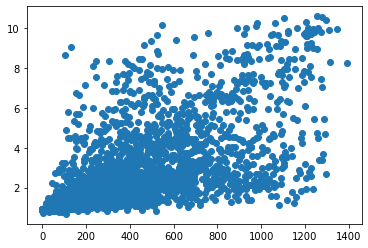

In [24]:
y = df_YMCA["Production"]
x = df_YMCA["SolarRad"]

plt.scatter(x, y)

## Résultat de l'analyse

Pas concluant, la granularité des données est peut être trop importante pour qu'on puisse voir quelque chose. 


## Granularité par jour

In [25]:
currentValue = df_YMCA.iloc[0]["Datetime"] + timedelta(days=1)
print(currentValue.date())

2014-01-08


In [26]:
currentValue = df_YMCA.iloc[0]["Datetime"] + timedelta(days=1)
dataset_daily_YMCA = []
granularity = []
for index, row in df_YMCA.iterrows():
    if row["Datetime"].date() == currentValue.date():
        granularity.append(row)
    if row["Datetime"].date() > currentValue.date():
        if len(granularity):
            totalProd = 0
            totalSolar = 0
            for r in granularity:
                #Site Datetime Prod Solar
                totalProd = totalProd + r["Production"]
                totalSolar = totalSolar + r["SolarRad"]
            #Push
            dataset_daily_YMCA.append([granularity[0]["Site"], currentValue.date(), totalProd/len(granularity), totalSolar/len(granularity)])
            granularity = []
        currentValue = row["Datetime"]
df_daily_YMCA = pd.DataFrame(dataset_daily_YMCA, columns = ["Site", "Datetime", "Production" ,"SolarRad"])

0.772


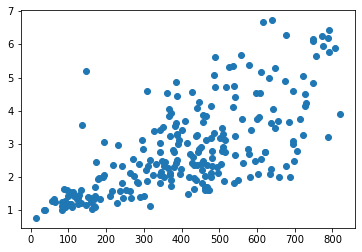

In [27]:
y = df_daily_YMCA["Production"]
x = df_daily_YMCA["SolarRad"]

print(min(y))
plt.scatter(x, y)

## Warning

La tendance est plus vers une stagnation de production peu importe la quantité d'énergie solaire donnée par la météo:

* Les données ne sont pas assez détaillées pour en comprendre la cause et donc rend peu probable de donner un modèle qui reflète une réalité.
* Les données de Londres sont anciennes (date de 2014), suite à plusieurs mails avec le support du portai openData de Londre, aucune personne ayant fourni les données ne sont encore dans le service et rends les informations complémentaires que l'ont demandais impossible à avoir (le nombre de panneaux que comporte un Site) __avec les données de générations suivant les différents sites nous rend imposible la tâche tellement les productions se ressemble__

In [28]:
X = np.array(df_daily_YMCA["SolarRad"])
x_shaped = X.reshape(-1, 1)

x_shaped_train = x_shaped[:-60]
x_shaped_test = x_shaped[-60:]


Y = np.array(df_daily_YMCA["Production"])
y_shaped = Y.reshape(-1, 1)

y_shaped_train = y_shaped[:-60]
y_shaped_test = y_shaped[-60:]

regr = linear_model.LinearRegression()

regr.fit(x_shaped_train, y_shaped_train)
y_pred = regr.predict(x_shaped_test)

print("Coefficient of determination: %.2f" % r2_score(y_shaped_test, y_pred))

Coefficient of determination: 0.09


Coefficient de * mais check si la droite calculée est bien croissante comme nous le supposons

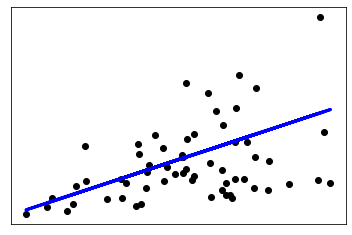

In [29]:
plt.scatter(x_shaped_test, y_shaped_test, color="black")
plt.plot(x_shaped_test, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

# Partie 2:

## Transform en UV index


utilisation de la formule __SolarRadation = 104 * UVIndex - 18.365__ trouver sur le site : https://digilent.com/blog/solar-powered-robot-uv-index-vs-solar-energy/

il faut faire une échelle de production PV concernant les indexs UV Calculées

* Arrondissement des indexs __>0.55 = 1__ & __<=0.55 = 0__ fonction Round()
* Moyenne des différents valeur pour avoir une table allant de UV 0 => 9

In [30]:
dataset_YMCA_uv = []
for index, row in df_daily_YMCA.iterrows():
    uv = round((row["SolarRad"]+18.365)/104)
    dataset_YMCA_uv.append([row["Site"],row["Datetime"], row["Production"], uv])
df_YMCA_uv = pd.DataFrame(dataset_YMCA_uv, columns = ["Site", "Datetime", "Production" ,"UVIndex"])

df_YMCA_uv.head()

,Site,Datetime,Production,UVIndex
0,Forest Road,2014-01-08,1.193000,1
1,Forest Road,2014-01-09,1.023000,1
2,Forest Road,2014-01-10,1.372125,2
3,Forest Road,2014-01-11,1.034000,2
4,Forest Road,2014-01-12,1.637250,1


In [31]:
data_uv = []
for x in range(10):
    df_uv = df_YMCA_uv.loc[lambda df: df["UVIndex"] == (x+1), :]
    if len(df_uv):
        data_uv.append([df_uv["UVIndex"].iloc[0], round(df_uv["Production"].mean(), 2)])


print(data_uv)

[[1, 1.38], [2, 1.84], [3, 2.24], [4, 2.9], [5, 3.0], [6, 3.77], [7, 4.04], [8, 5.45]]


## Hypothèse

Nous prenon l'hypothèse que lorsque l'UV est au maximum, la production est à 100%

https://mypower.engie.fr/energie-solaire/conseils/puissance-panneau-solaire.html
suite au site ci dessus, nous prenons la valeur référence du maximum possible de production d'un panneau(420kwh) et la divisons en 365 pour avoir la production journalière d'un panneau.

In [32]:
max_prod = 420/365
pourcentage = 100/5.45
for x in data_uv:
    x[1] = round((max_prod/100)*(pourcentage*x[1]), 2)
print(data_uv)
df_uv = pd.DataFrame(data_uv, columns = ["UVIndex", "MeanProduction"])

[[1, 0.29], [2, 0.39], [3, 0.47], [4, 0.61], [5, 0.63], [6, 0.8], [7, 0.85], [8, 1.15]]


## Match la météo de Namur sur les données calculées

### Import datasets

In [33]:
def get_df_with_prod(df):
    df_2021 = df[["DATE", "UV_INDEX"]]
    df_2021 = df_2021.rename(columns = {"UV_INDEX": "UVIndex", "DATE":"Date"})
    data_namur_2021 = []
    for index, row in df_2021.iterrows():
        uv = df_uv.loc[lambda df: df["UVIndex"] == row["UVIndex"], :]
        data_namur_2021.append([datetime.strptime(row["Date"], "%Y-%m-%d"), row["UVIndex"], uv["MeanProduction"].iloc[0]])
    return pd.DataFrame(data_namur_2021, columns = ["Date", "UVIndex", "MeanProduction"])

In [34]:
dfs_weather = []
for x in range(2009,2022):
    path = r"./datasets/meteo/export-namur" + str(x) + ".csv"
    dfs_weather.append(get_df_with_prod(pd.DataFrame(pd.read_csv(path))))

### Get des données X,Y pour la régression linéaire de chaque jour

In [35]:
def get_prods_dates(dfs):
    prods_dates = []
    df_dates = dfs[0]["Date"]
    for date in df_dates:
        currentDate = date
        prods = []
        dates = []
        for df_weather in dfs:
            df = df_weather.loc[lambda df: df["Date"] == currentDate, :]
            currentDate = currentDate + timedelta(days=365)
            if currentDate.year % 4 == 0:  
                currentDate = currentDate + timedelta(days=1)
            prods.append(df["MeanProduction"].iloc[0])
            dates.append(df["Date"].iloc[0].year)    
        prods_dates.append([dates, prods])   
    return prods_dates

dates_prods = get_prods_dates(dfs_weather)
#Value index 0 => 1 janvier  len(dates_prods) => 31 décembre

### Get l'ensemble des droites pour chaque jour que compose une année (hors bisextile)

In [36]:
def get_linear_regression(prods_dates):
    x = np.array(prods_dates[0]).reshape(-1,1)
    y = np.array(prods_dates[1]).reshape(-1,1)
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    pente = (y_pred[1][0] - y_pred[0][0]) / (x[1][0] - x[0][0])
     
    plt.figure(figsize=(4, 3))
    ax = plt.axes()
    ax.scatter(x, y, color="black")
    ax.plot(x, y_pred, color="blue", linewidth=3)   
    ax.set_xlabel('Date')
    ax.set_ylabel('Production')
    #[x[len(x)-1][0], y_pred[len(y_pred)-1][0], pente]
    return [x[len(x)-1][0], y_pred[len(y_pred)-1][0], pente]

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_6988\913313898.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4, 3))


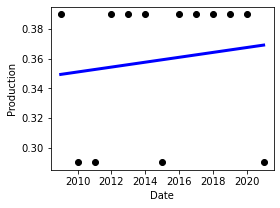

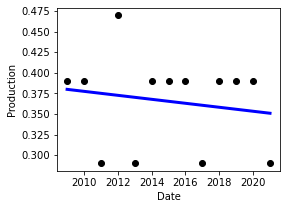

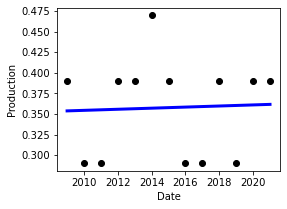

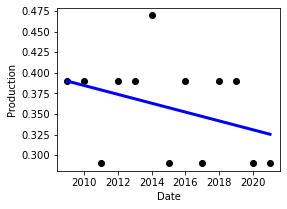

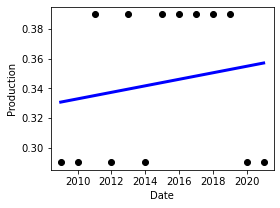

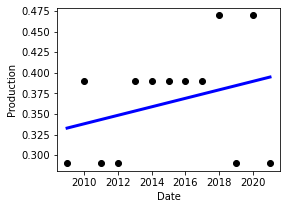

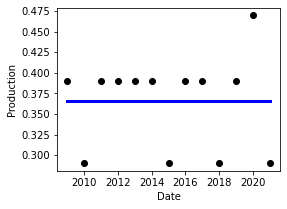

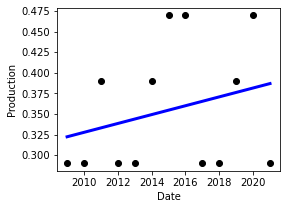

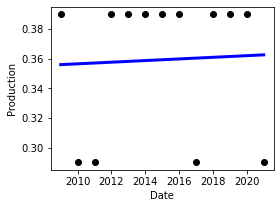

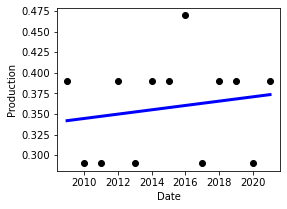

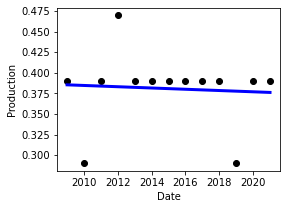

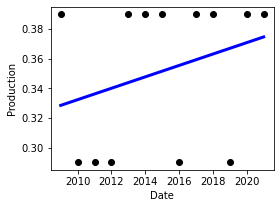

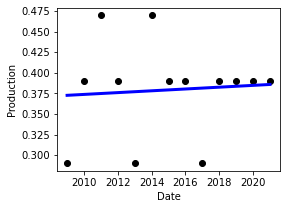

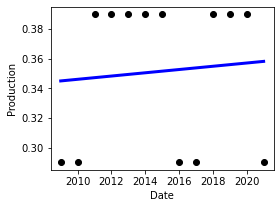

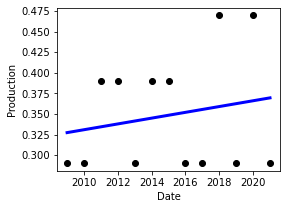

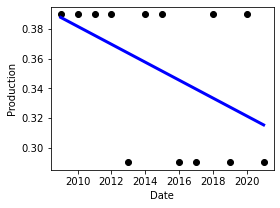

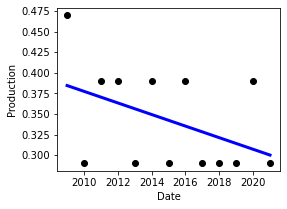

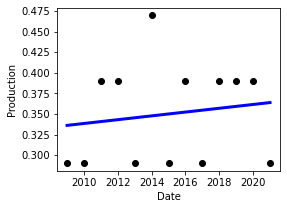

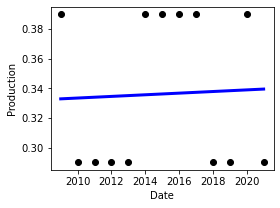

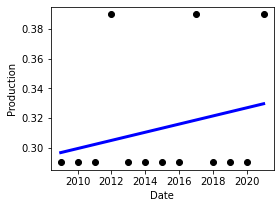

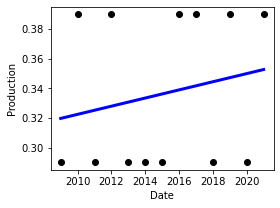

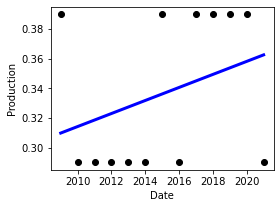

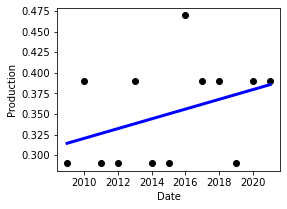

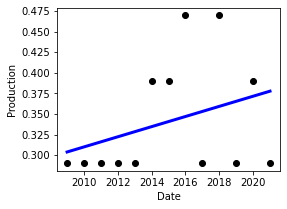

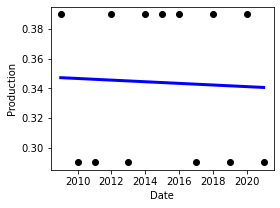

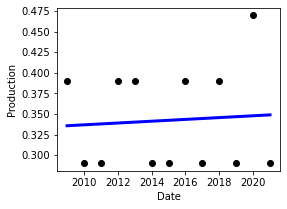

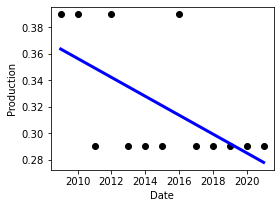

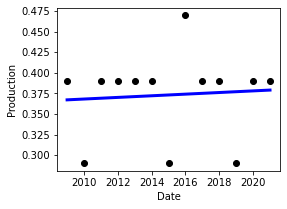

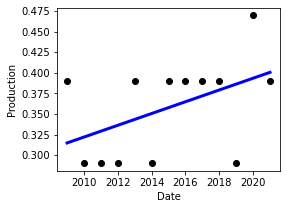

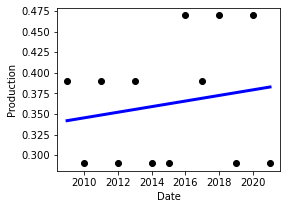

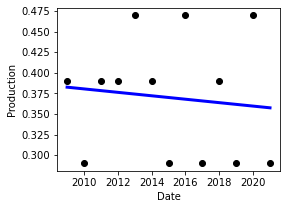

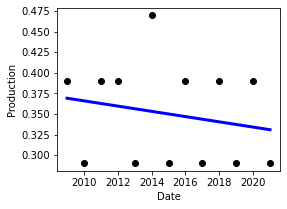

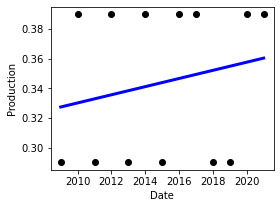

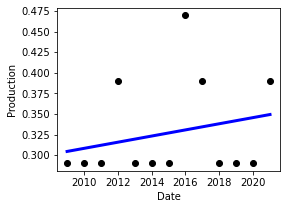

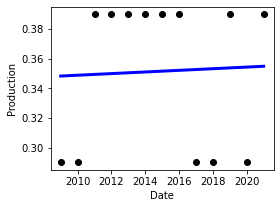

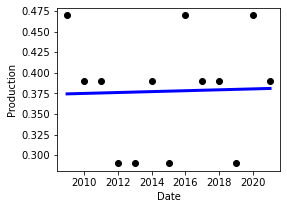

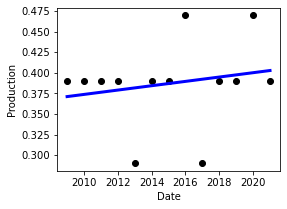

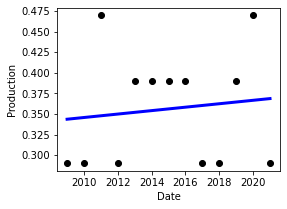

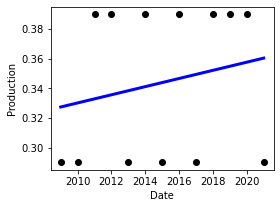

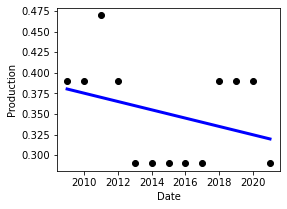

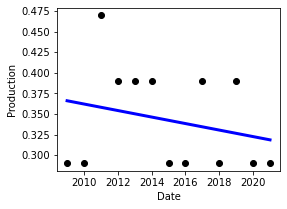

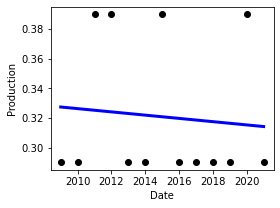

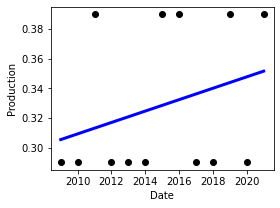

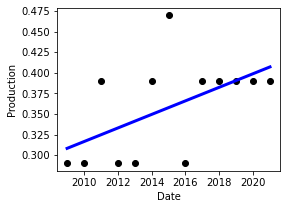

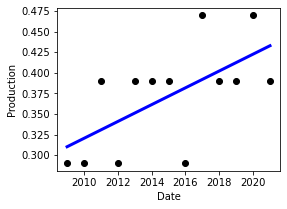

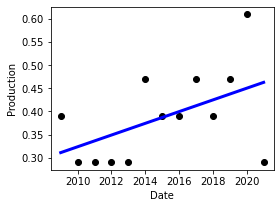

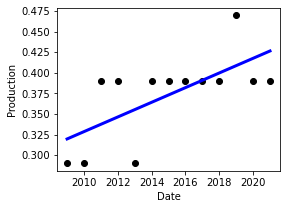

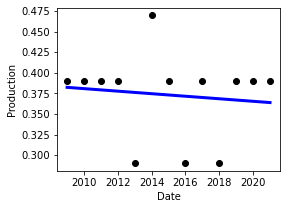

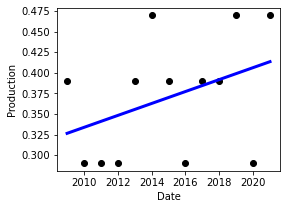

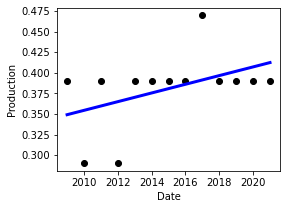

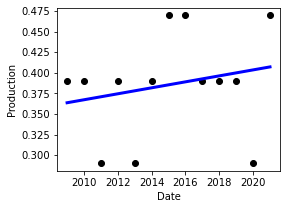

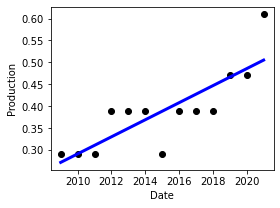

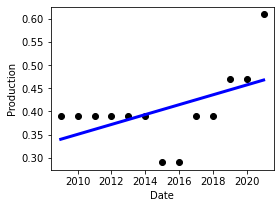

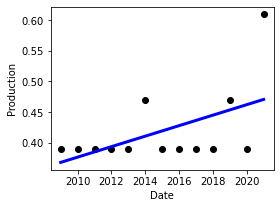

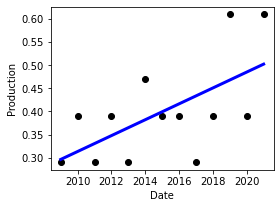

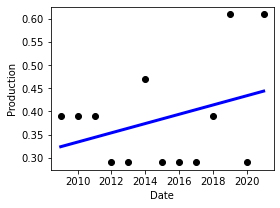

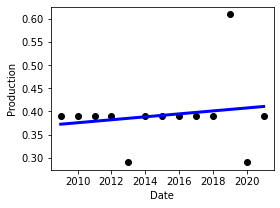

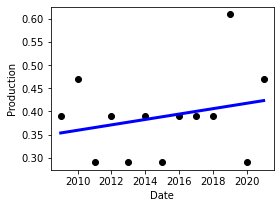

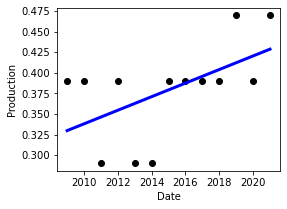

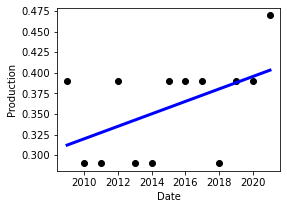

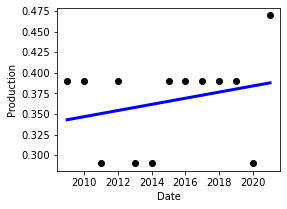

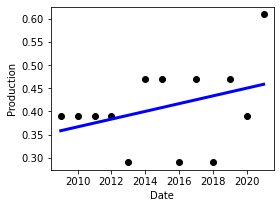

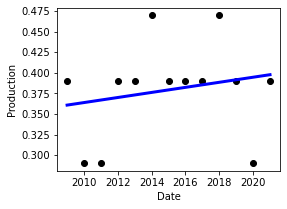

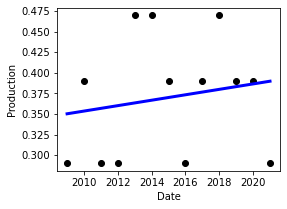

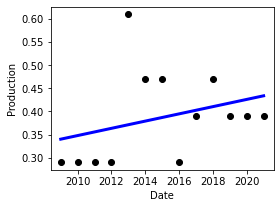

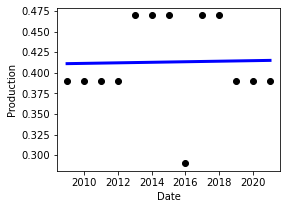

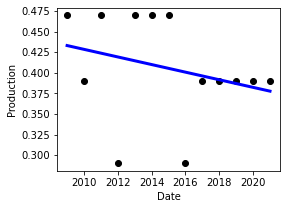

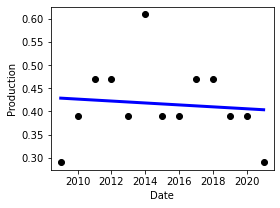

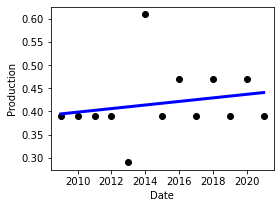

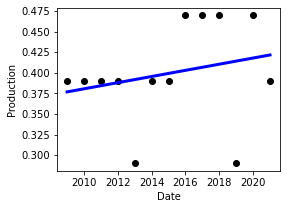

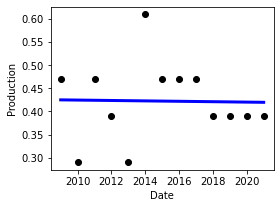

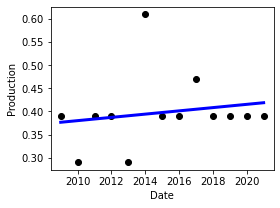

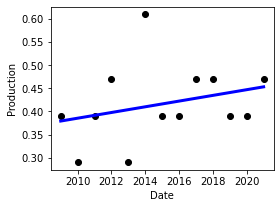

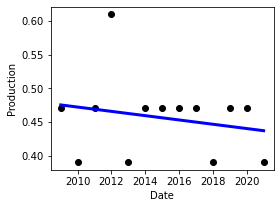

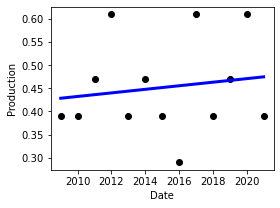

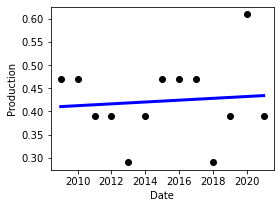

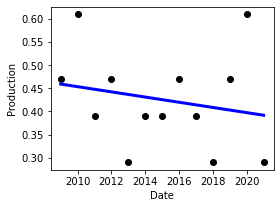

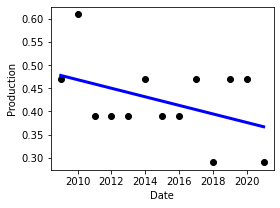

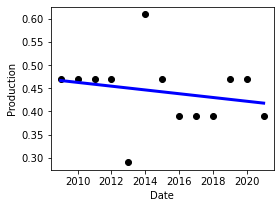

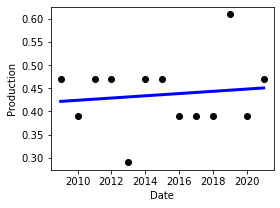

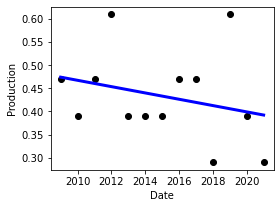

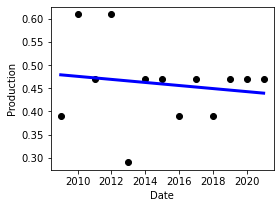

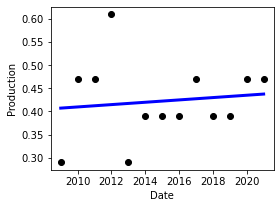

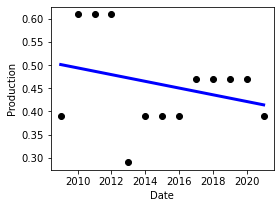

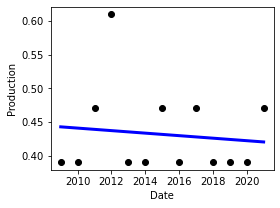

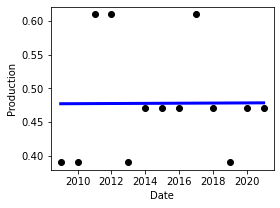

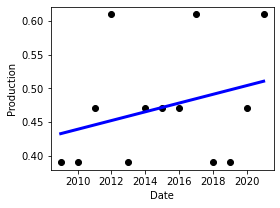

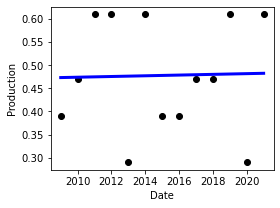

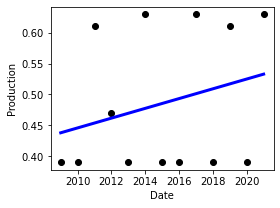

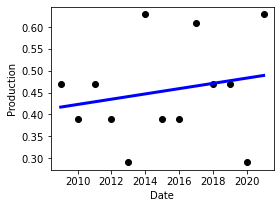

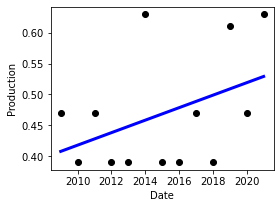

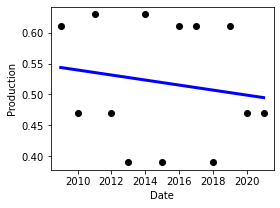

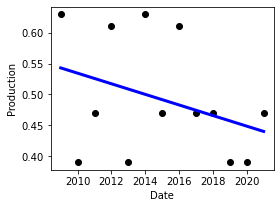

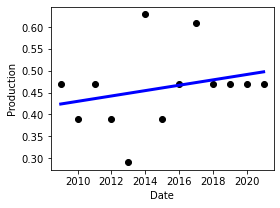

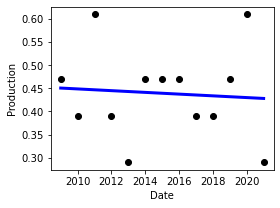

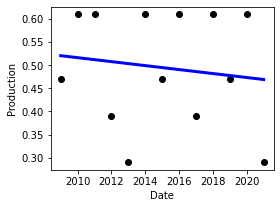

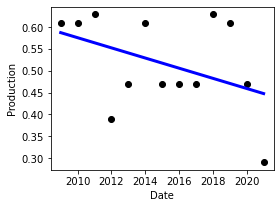

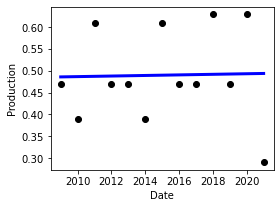

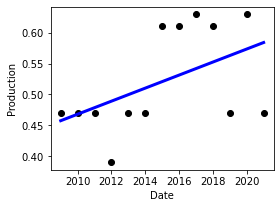

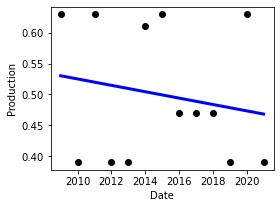

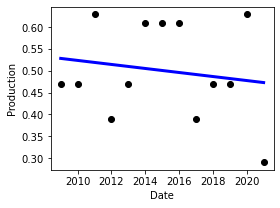

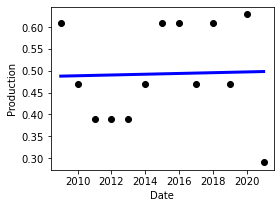

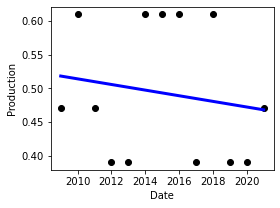

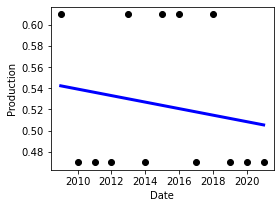

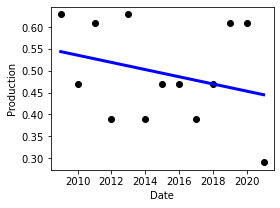

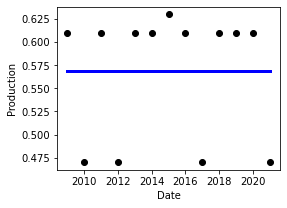

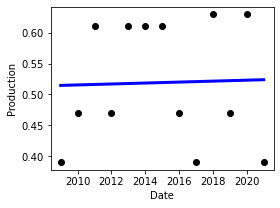

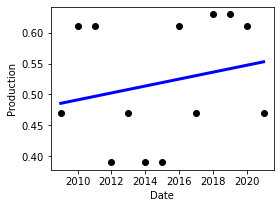

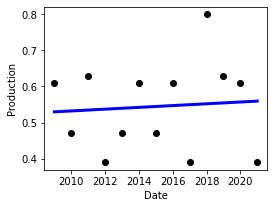

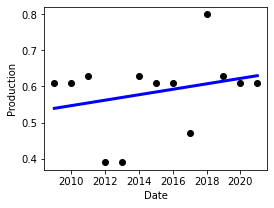

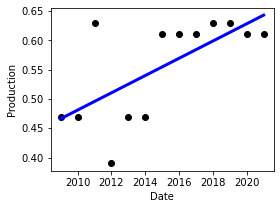

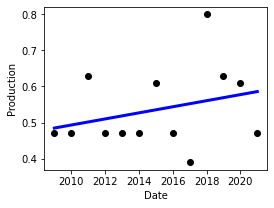

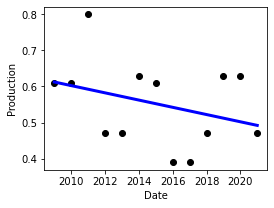

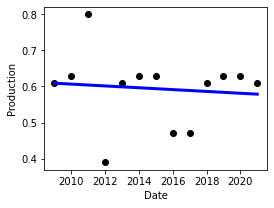

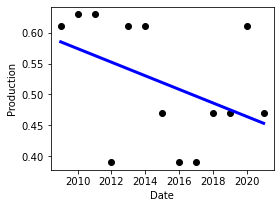

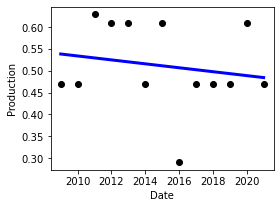

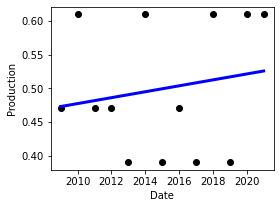

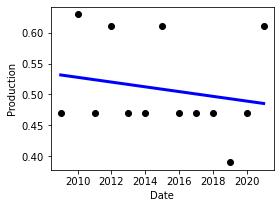

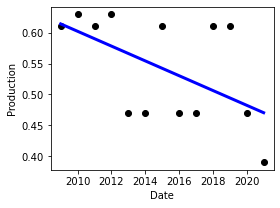

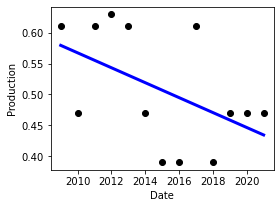

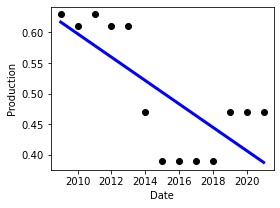

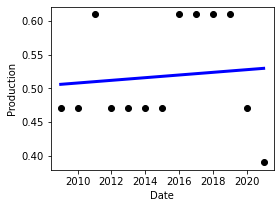

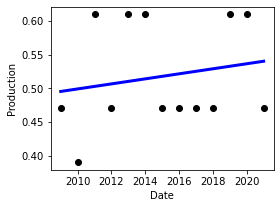

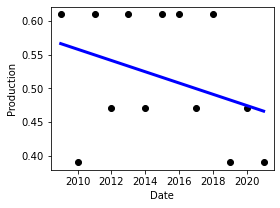

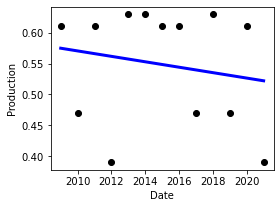

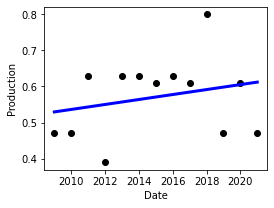

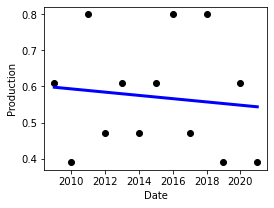

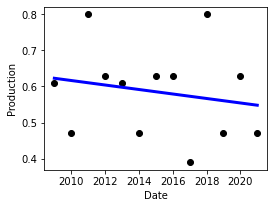

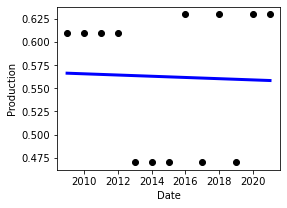

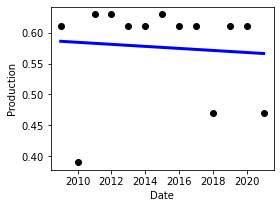

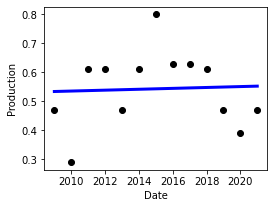

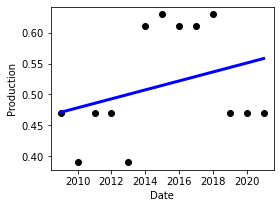

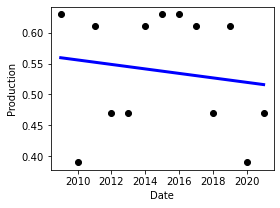

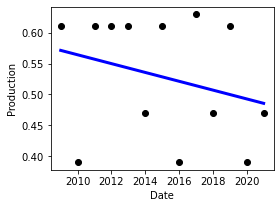

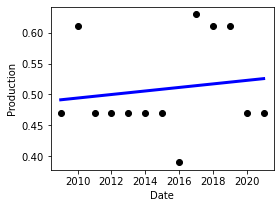

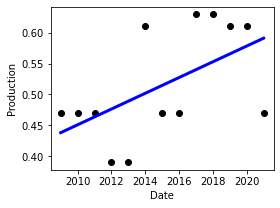

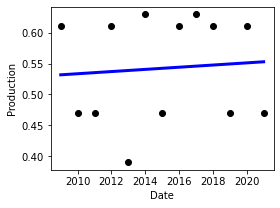

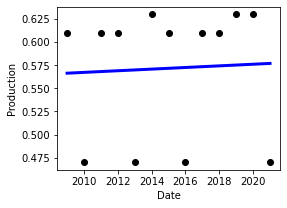

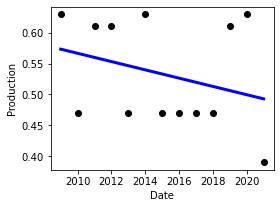

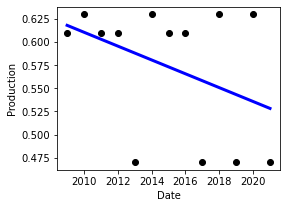

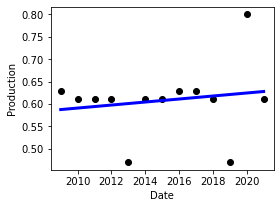

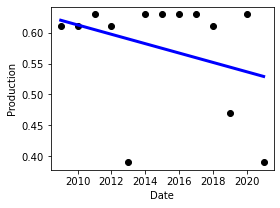

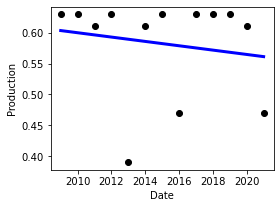

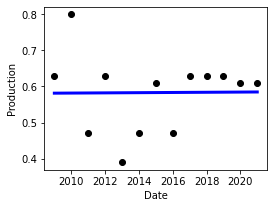

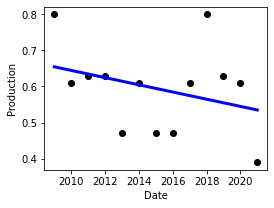

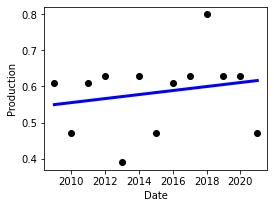

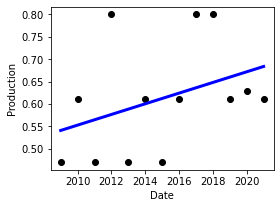

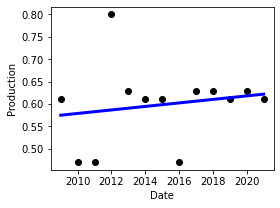

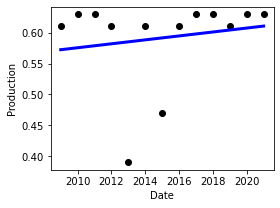

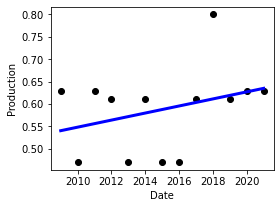

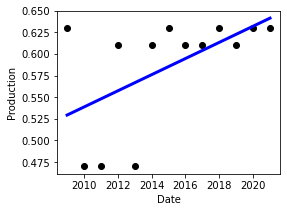

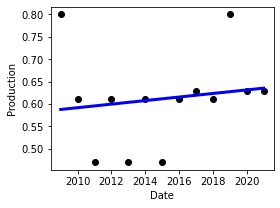

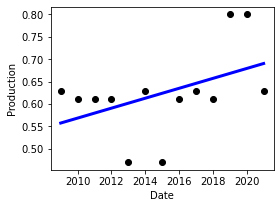

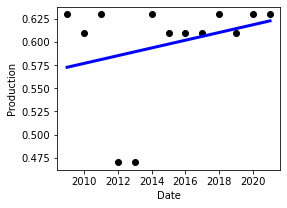

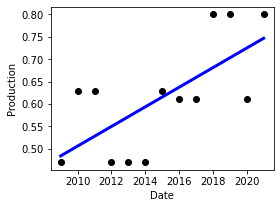

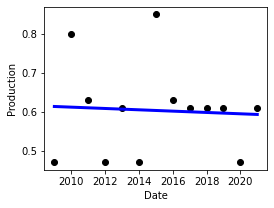

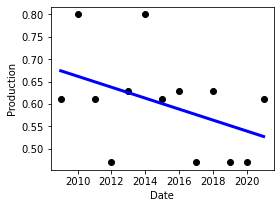

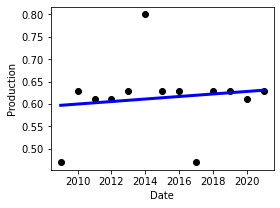

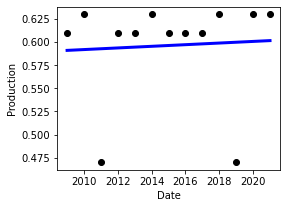

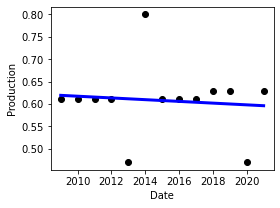

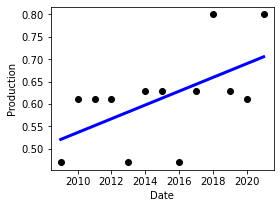

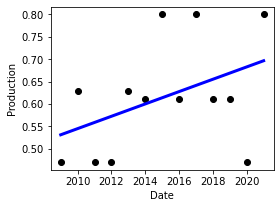

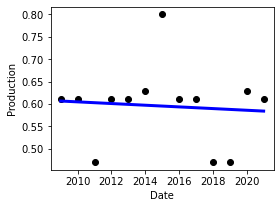

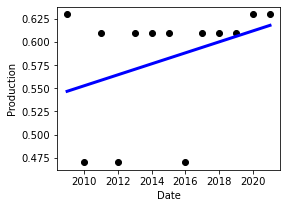

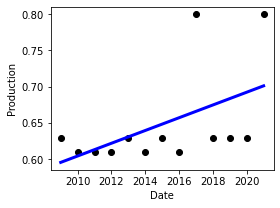

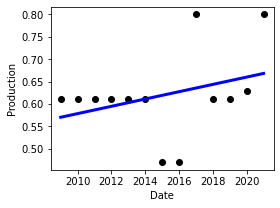

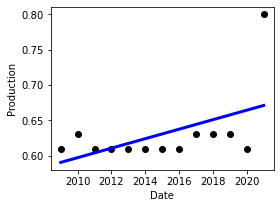

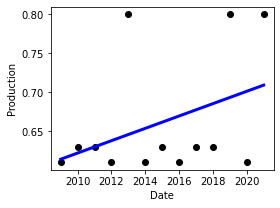

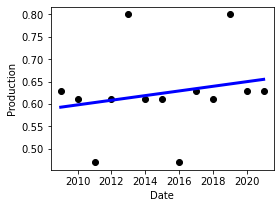

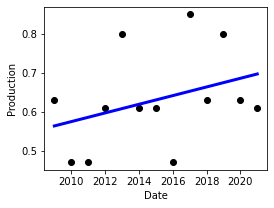

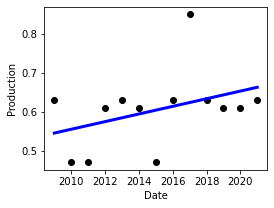

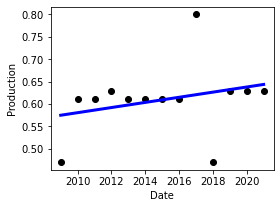

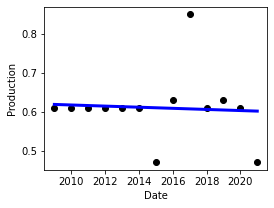

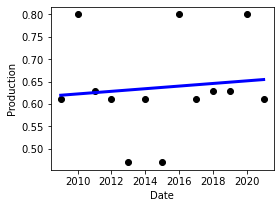

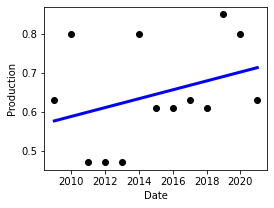

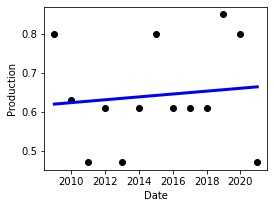

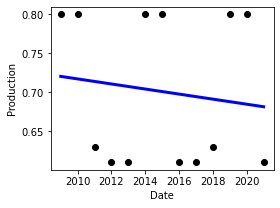

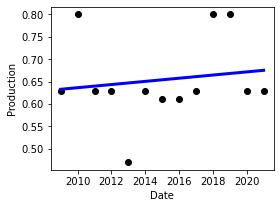

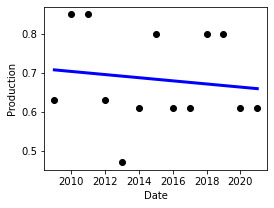

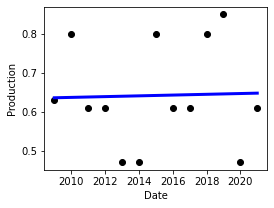

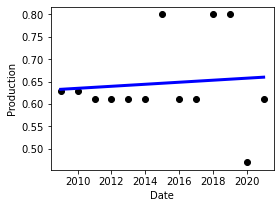

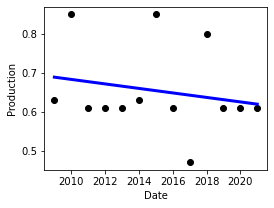

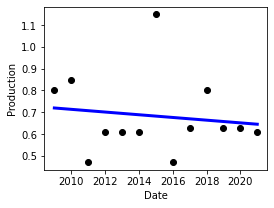

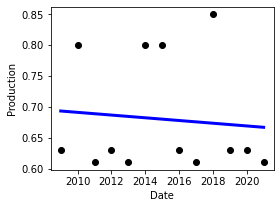

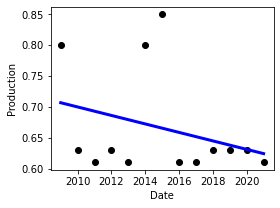

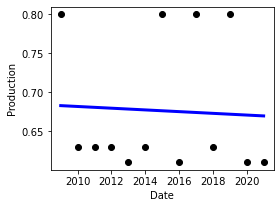

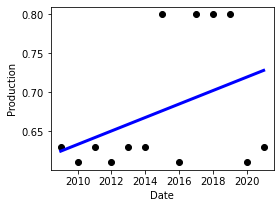

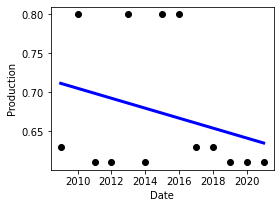

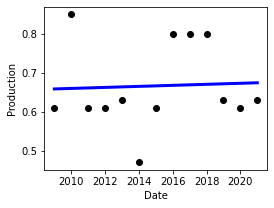

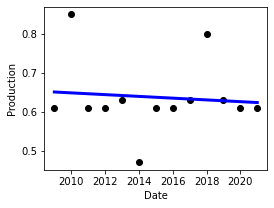

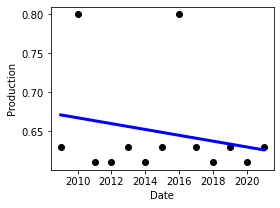

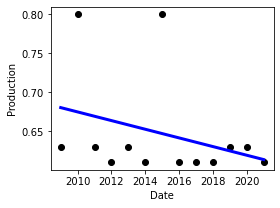

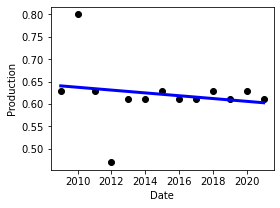

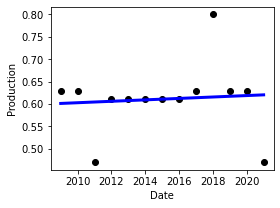

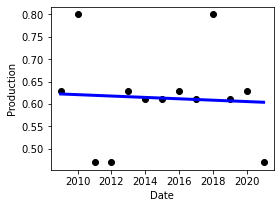

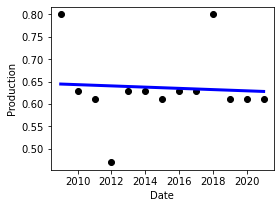

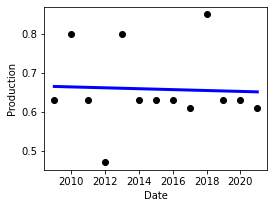

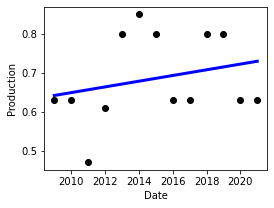

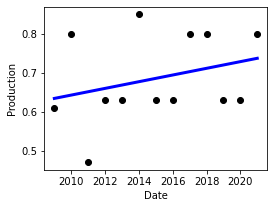

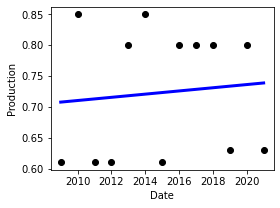

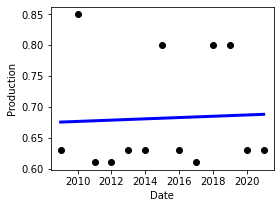

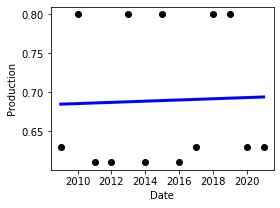

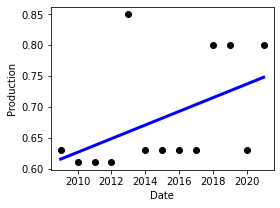

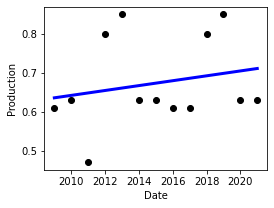

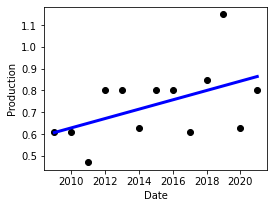

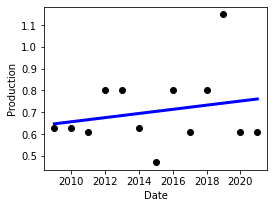

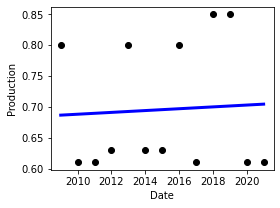

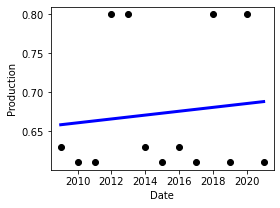

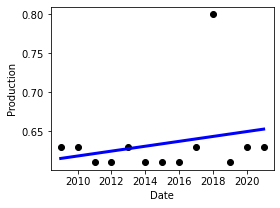

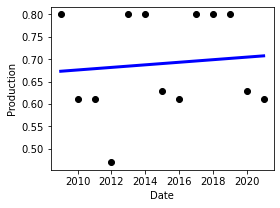

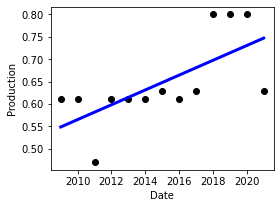

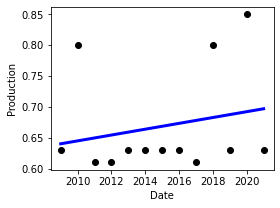

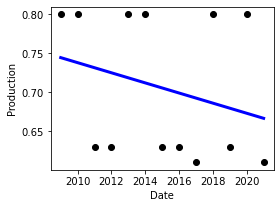

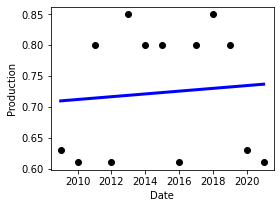

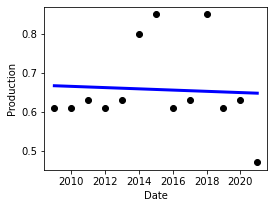

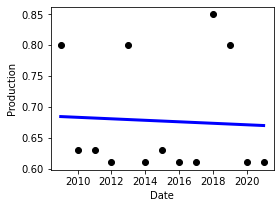

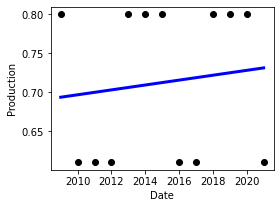

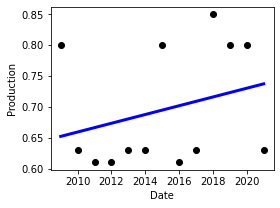

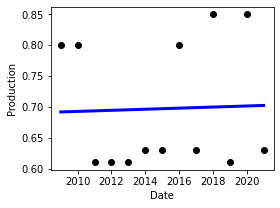

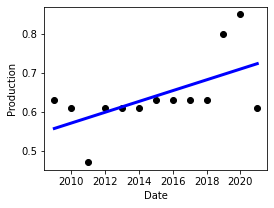

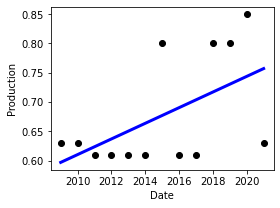

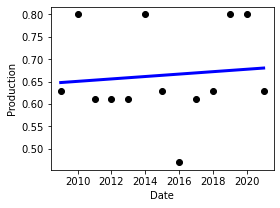

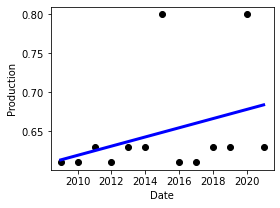

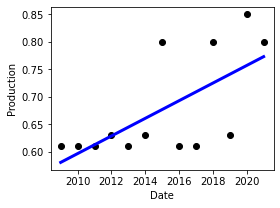

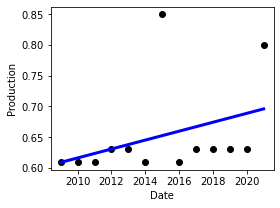

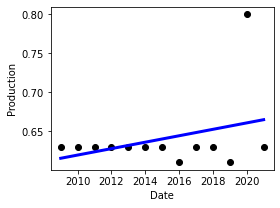

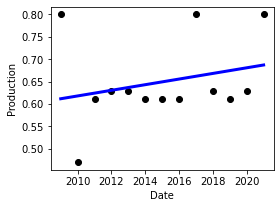

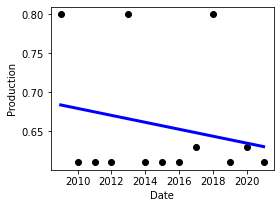

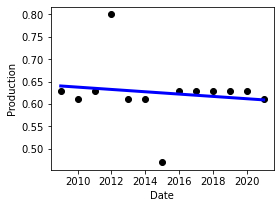

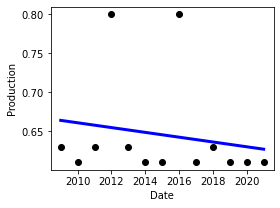

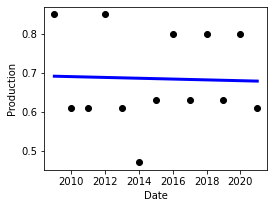

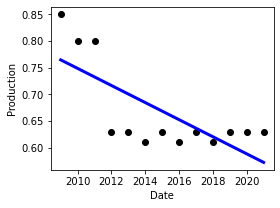

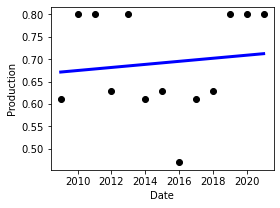

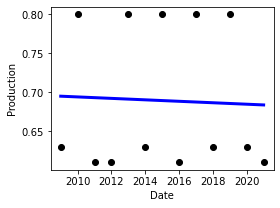

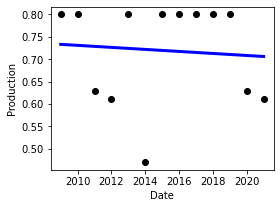

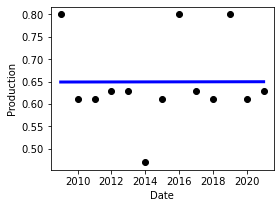

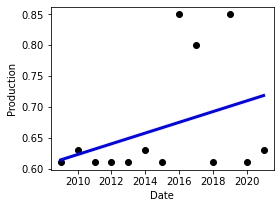

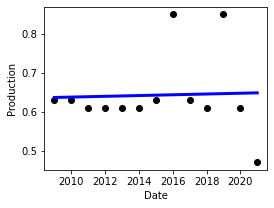

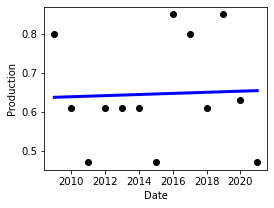

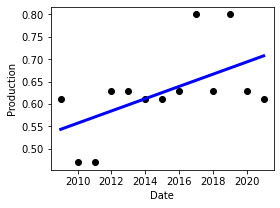

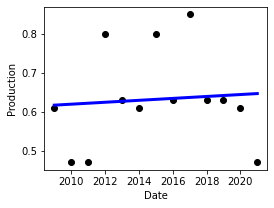

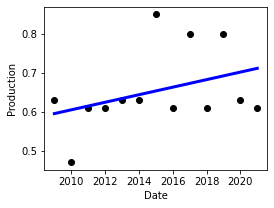

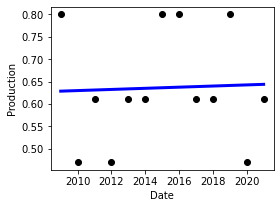

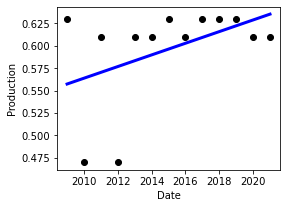

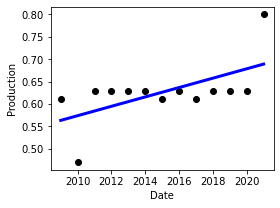

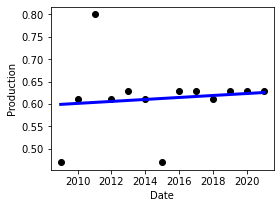

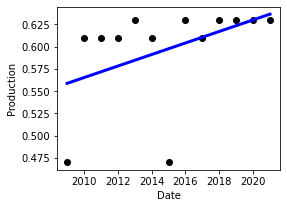

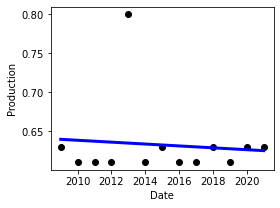

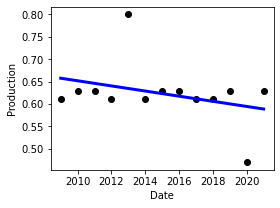

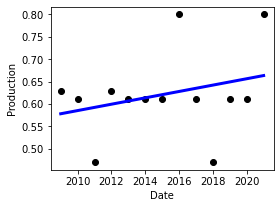

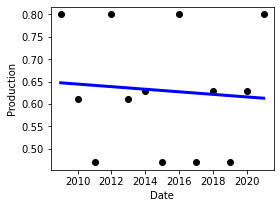

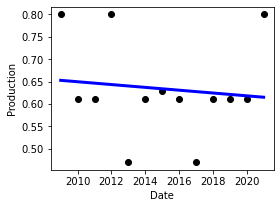

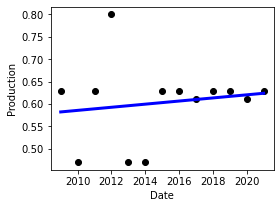

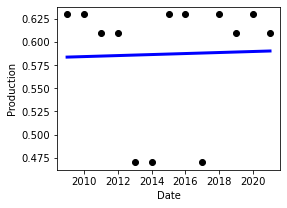

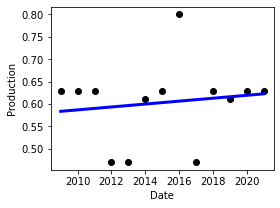

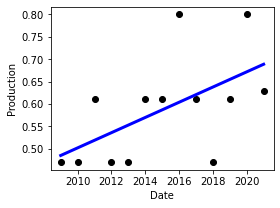

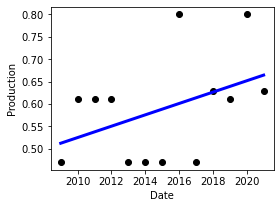

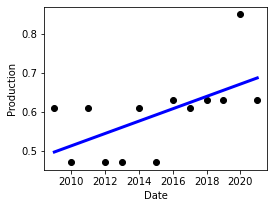

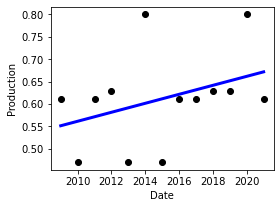

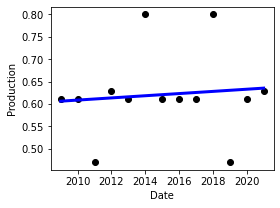

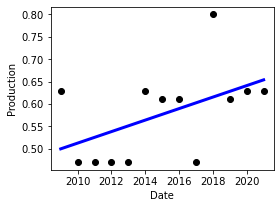

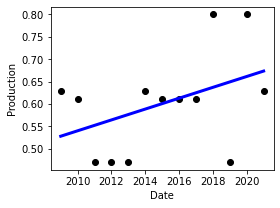

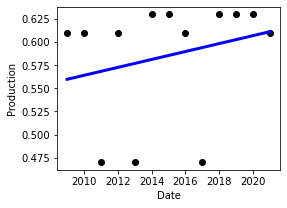

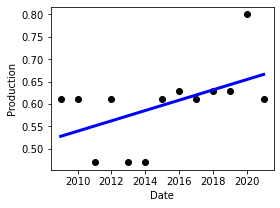

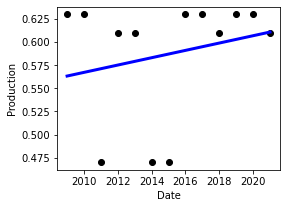

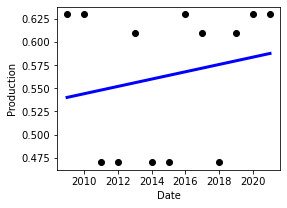

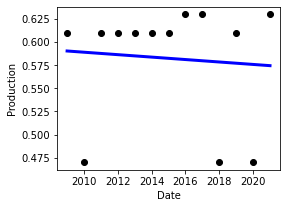

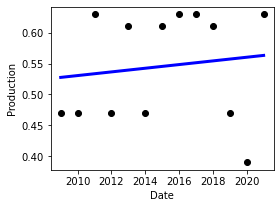

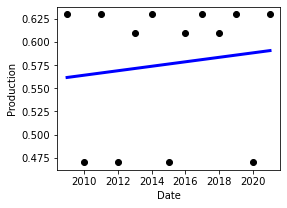

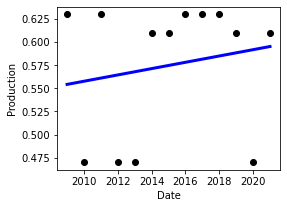

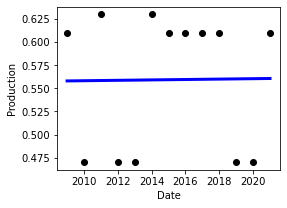

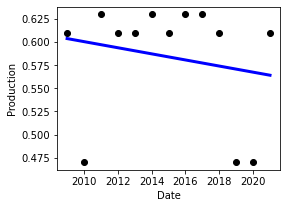

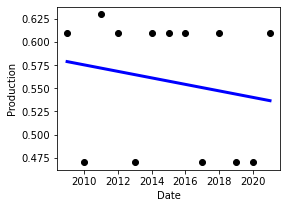

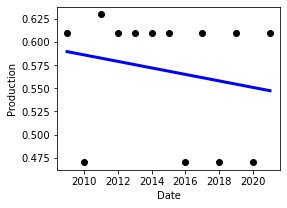

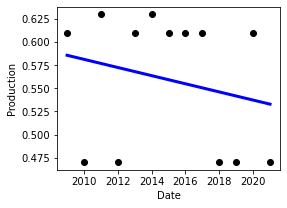

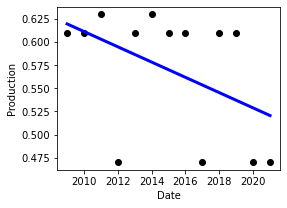

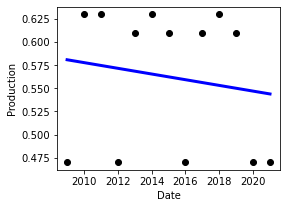

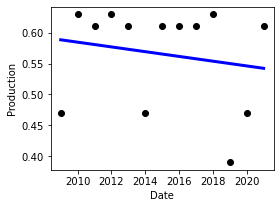

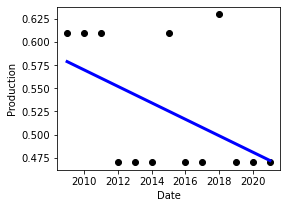

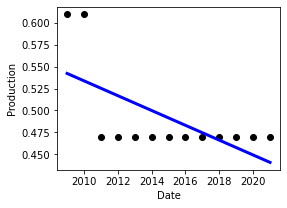

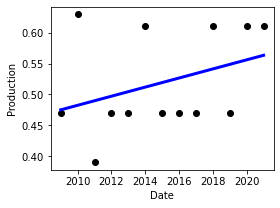

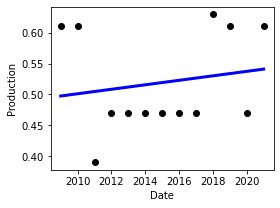

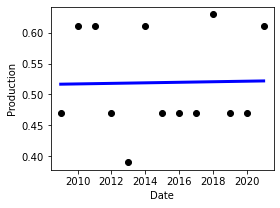

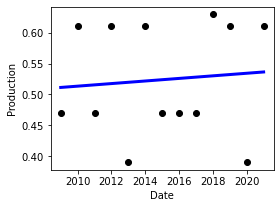

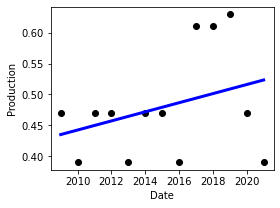

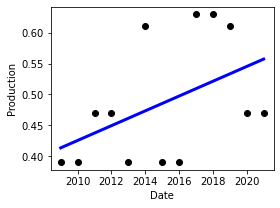

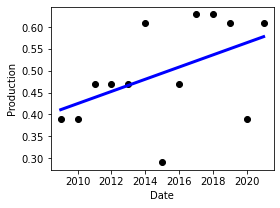

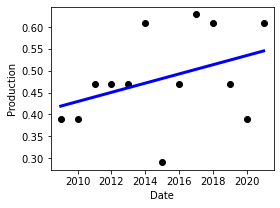

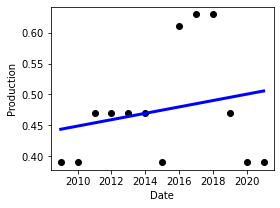

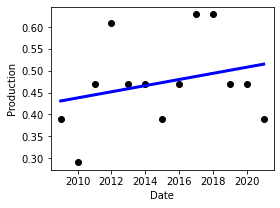

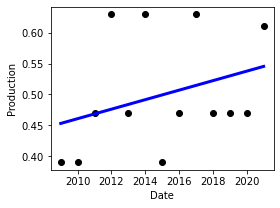

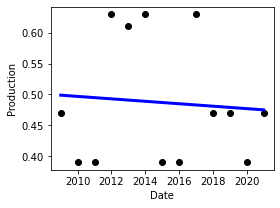

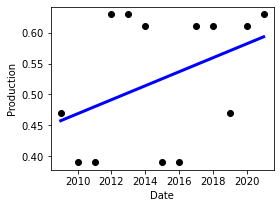

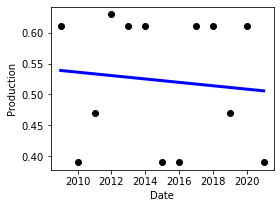

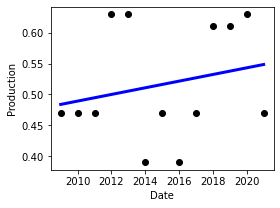

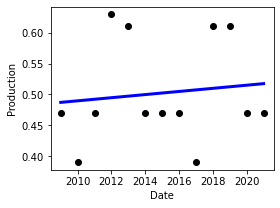

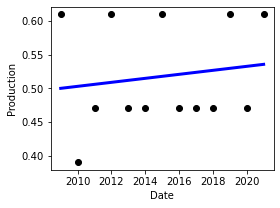

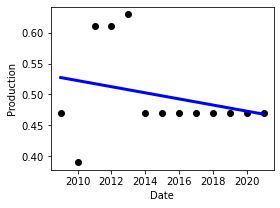

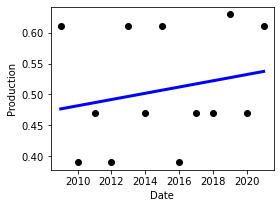

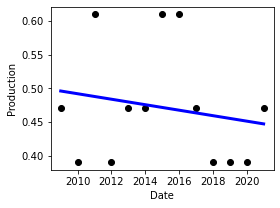

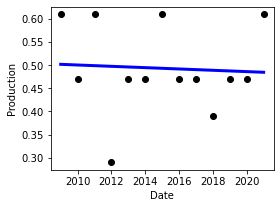

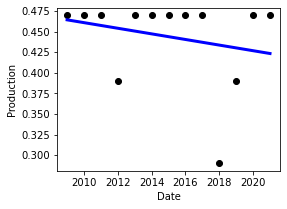

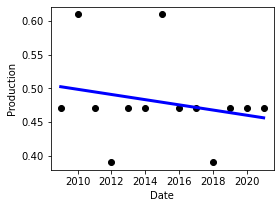

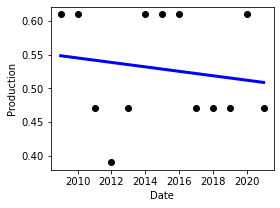

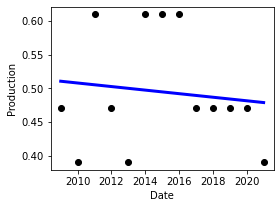

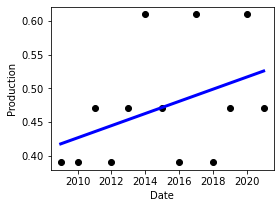

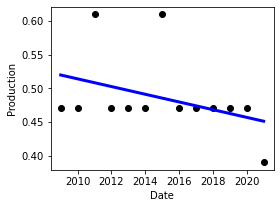

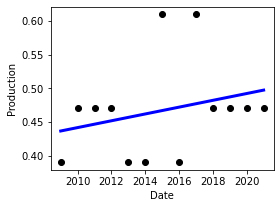

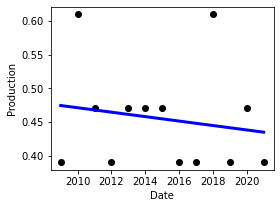

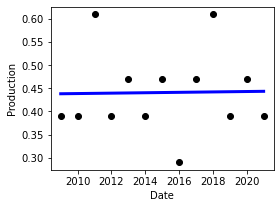

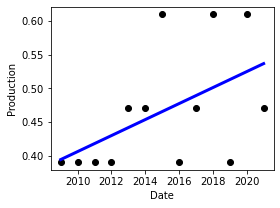

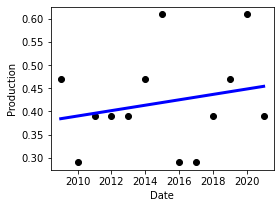

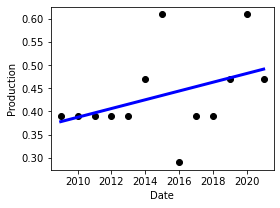

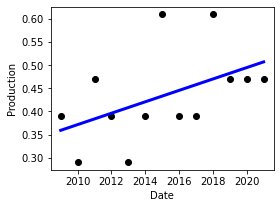

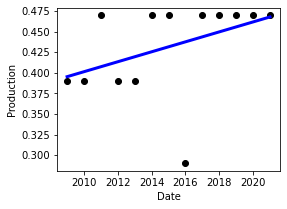

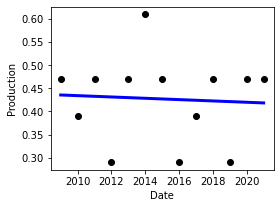

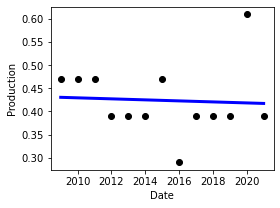

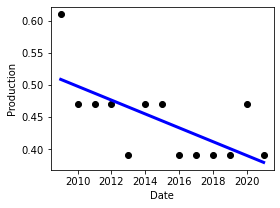

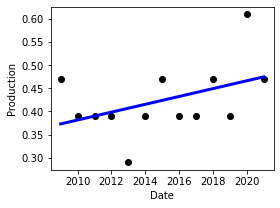

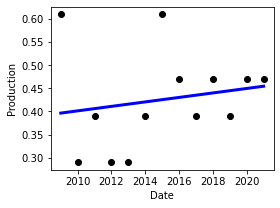

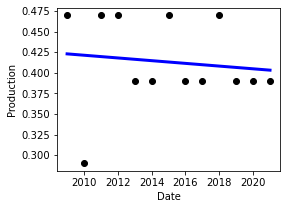

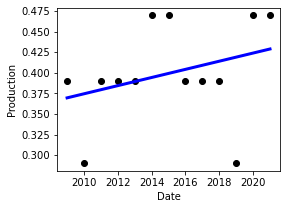

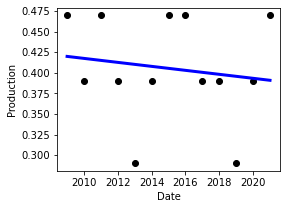

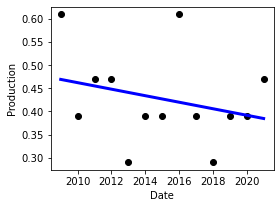

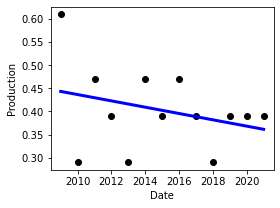

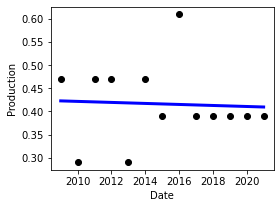

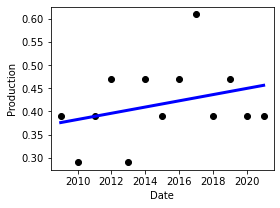

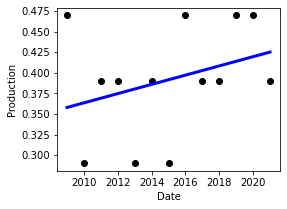

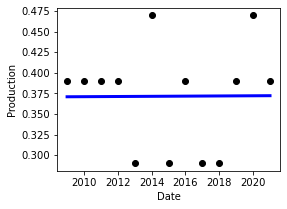

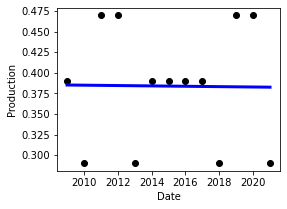

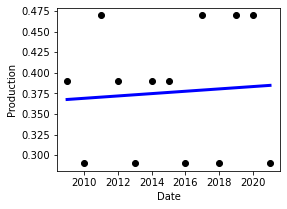

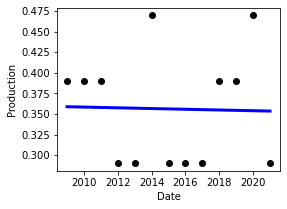

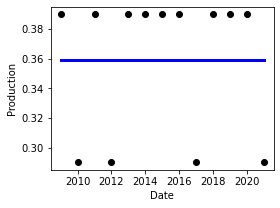

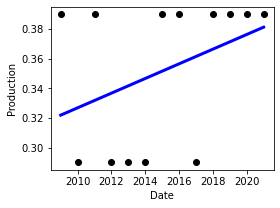

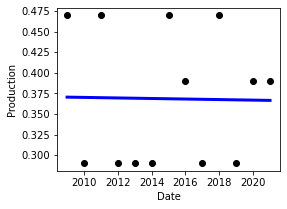

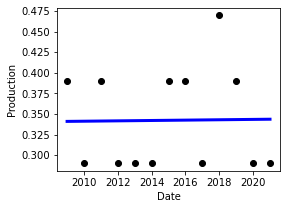

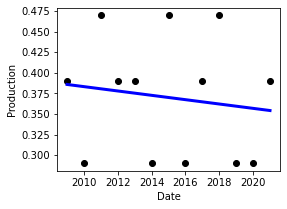

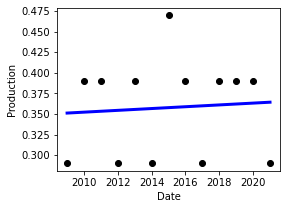

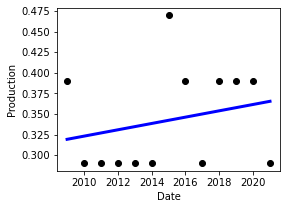

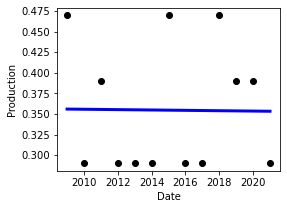

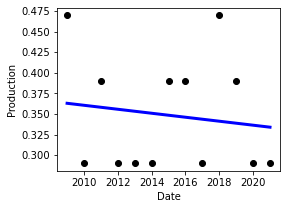

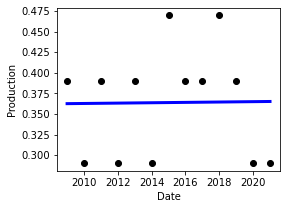

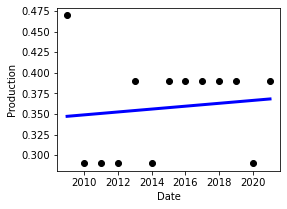

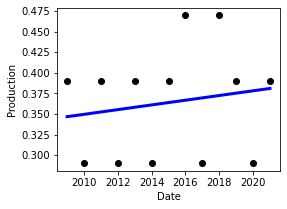

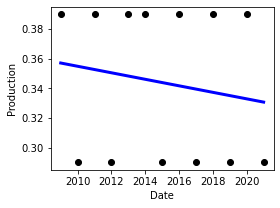

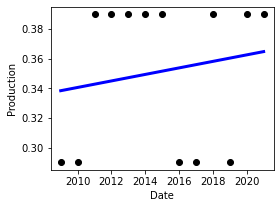

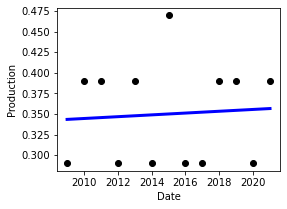

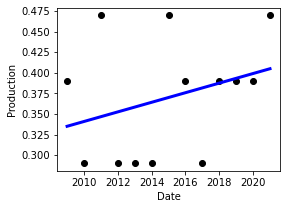

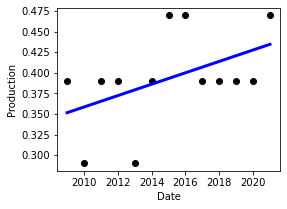

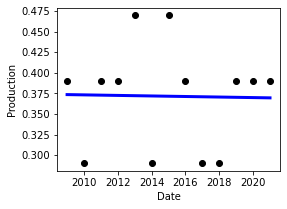

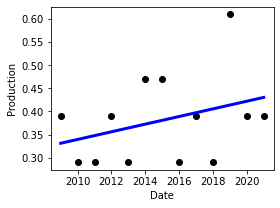

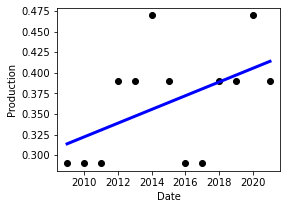

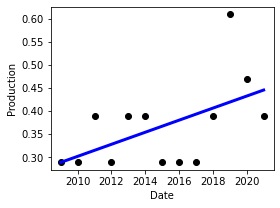

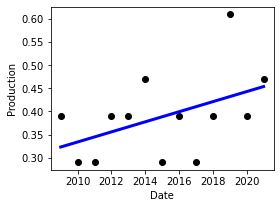

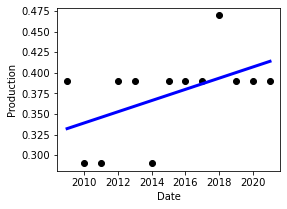

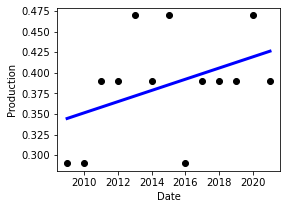

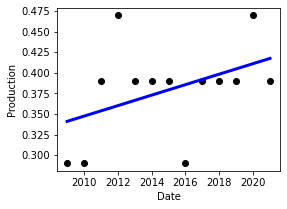

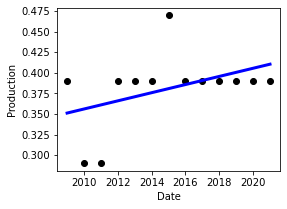

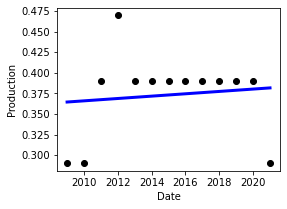

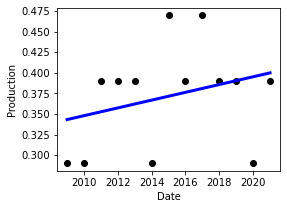

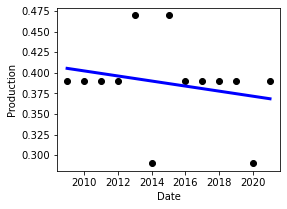

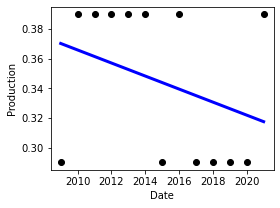

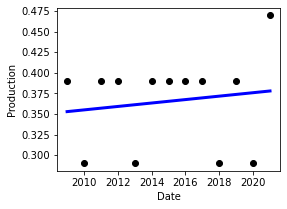

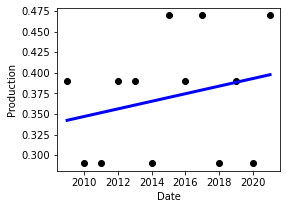

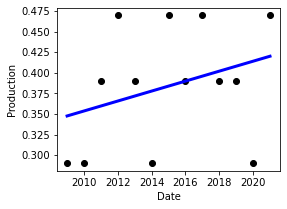

In [37]:
lines= []
for prod_date in dates_prods:
    lines.append(get_linear_regression(prod_date))

# Calcul de production d'un panneau solaire sur l'année 2023

In [38]:
prod_totale = 0
for line in lines:
    prod_totale =  prod_totale + (line[1] + 2*line[2])
print(prod_totale)


data = {
    "production": prod_totale
}
json_string = json.dumps(data)
with open('json_data.json', 'w') as outfile:
    outfile.write(json_string)

191.1963736263738
